### 이미지 - 전이학습 및 미세조정
- ConvNet을 이용한 전이 학습

#### 사전학습 : 대량의 데이터셋에 대해 학습된 모델
1. Feature Extraction

   - 사전학습된 모델을 새로운 이미지 데이터에 대해 유의미한 feature을 뽑아내는 용도로 사용함

   - 최종 태스크를 수행할 수 있는 classifier만을 더해 사적학습된 모델이 만든 feature map을 새로운 태스크 수행에 활용

   - 이 방법은 전체 모델을 다시 학습할 필요가 없기 때문에 학습 비용 측면에서 유리하다.

2. Fine-tuning

   - 사전학습된 모델의 윗부분 몇 개의 layer은 고정하지 않고, 새로 추가한 classifier과 더불어 학습함

   - 모델의 밑단에서는 lower level representation을 학습하기 때문에 새로운 태스크에 대해서도 재학습할 필요가 없지만, 
     고차원의 representation을 배워야 하는 윗단 레이어는 최종 태스크에 대해 fine-tuning함으로써 높은 성능을 낼 수 있다는 아이디어

##### Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

##### 데이터 전처리

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# 해당 url의 데이터를 받아옴
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# _URL_에 존재하는 'cats_and_dogs.zip'을 os로 받은 PATH에 파일명으로 다운받음
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# train, validation data 경로 읽기
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# batchsize, image size 지정
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

# image directory에서 tf.data.Dataset을 생성함
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# validation dataset 생성

# train data는 강아지 / 고양이 사진 2000장 포함
# validation data는 강아지 / 고양이 사진 1000장 포함

Found 1000 files belonging to 2 classes.


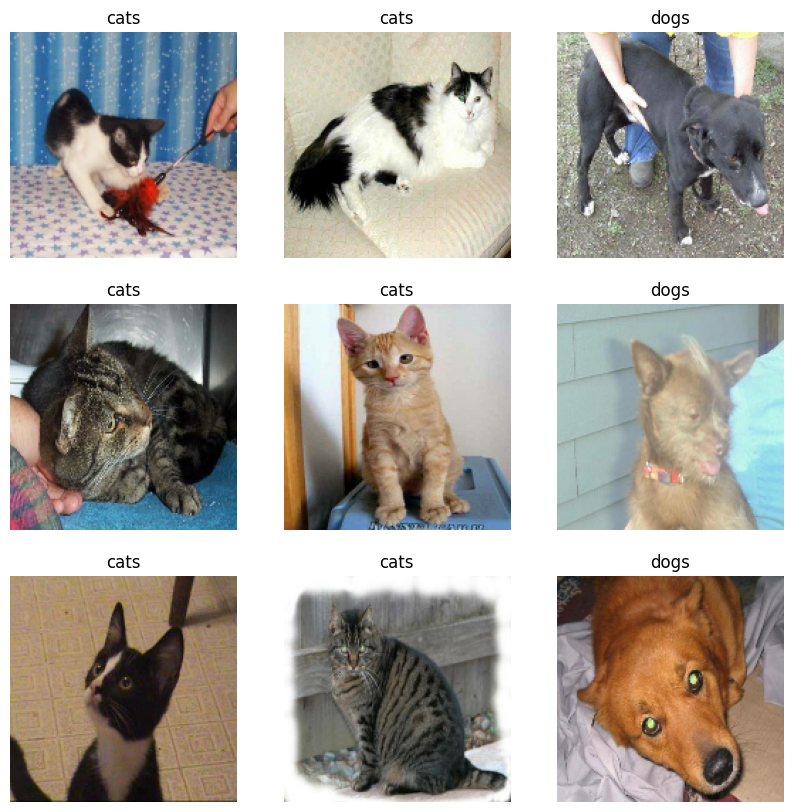

In [4]:
class_names = train_dataset.class_names
# train dataset의 레이블 값 선언

plt.figure(figsize=(10, 10))

# take를 통해 해당 배치를 1번 반복함, 
# dataset.take(n): dataset에서 데이터를 앞에서부터 n개 뽑은 데이터셋을 반환함
for images, labels in train_dataset.take(1):
  for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 이미지 표현을 위해 numpy 배열 dtype을 uint8로 지정
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off") 

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
# val_dataset에서 사용할 수 있는 데이터 배치 수를 확인함
# https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality

test_dataset = validation_dataset.take(val_batches // 5)
# 데이터셋에 test_data가 없으므로 validation data 중 20%를 test dataset으로 지정

validation_dataset = validation_dataset.skip(val_batches // 5)
# skip을 통해 test_dataset으로 빼둔 (val_batches//5)만큼을 제외하고 나머지를 validation으로 사용

##### 성능 높이기

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
# https://www.tensorflow.org/guide/data_performance?hl=ko
# tf.data의 런타임 값을 동적으로 조정하도록 tf.data.AUTOTUNE 설정


# buffered prefecthing을 사용해 I/O에 막힘이 없이 이미지를 읽어올 수 있게 함
# 동적으로 조정된 AUTUTUNE을 받아 prefetch를 호출하여 데이터를 효율적으로 준비함
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

##### 데이터 증강

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'), #  이미지 가로 반전
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
  tf.keras.layers.RandomRotation(0.2), # 이미지를 랜덤으로 (degree : 0.2 만큼) 회전
  # https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation
])
# data_augmentation을 통해 overfitting 방지 및 성능을 향상시킴
# 레이어로 구성하여 model.fit을 통해 호출할 때 적용되도록 합
# model.evaluate 또는 model.predict에는 augmentation layer가 활성화되지 않음

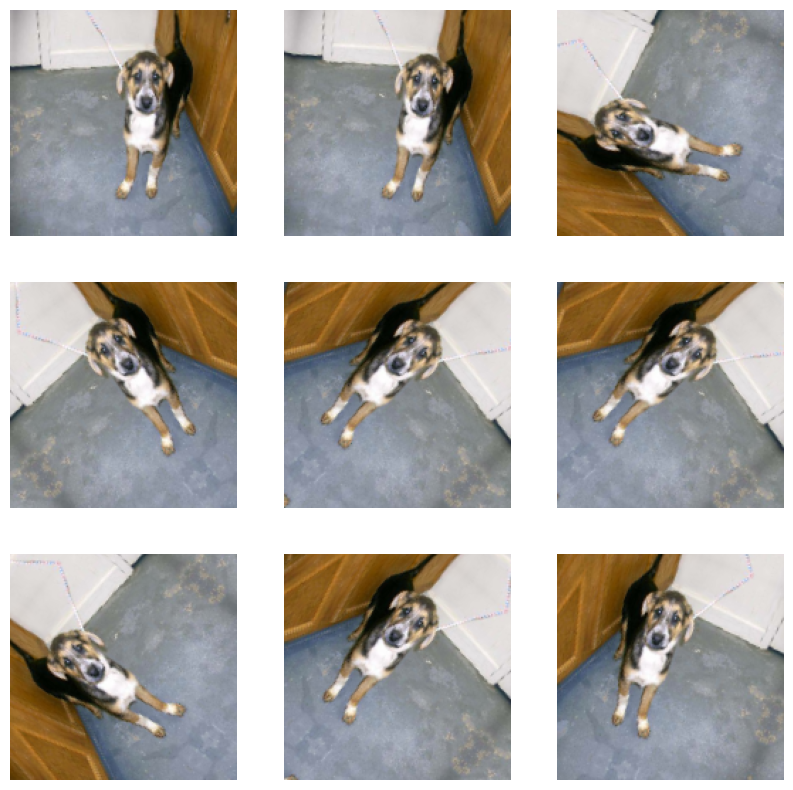

In [8]:
# data_augmentation 적용 예시 확인

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # tf.expand_dims를 통해 기존 이미지의 차원을 확장함 (first_image : 차원이 늘려질 배열, 0(axis) : 몇 번째 차원의 크기를 늘릴 것인지)
    # 차원 확장 후 이미지 증강 기법 적용
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

##### 픽셀 재조정

##### MobileNetV2
- 이미지넷 데이터에 대해 사전학습된 MobileNetV2를 활용함 
- ImageNet 데이터는 1000개의 카테고리에 대해 140만장의 이미지를 포함하는 라지 스케일 데이터셋임

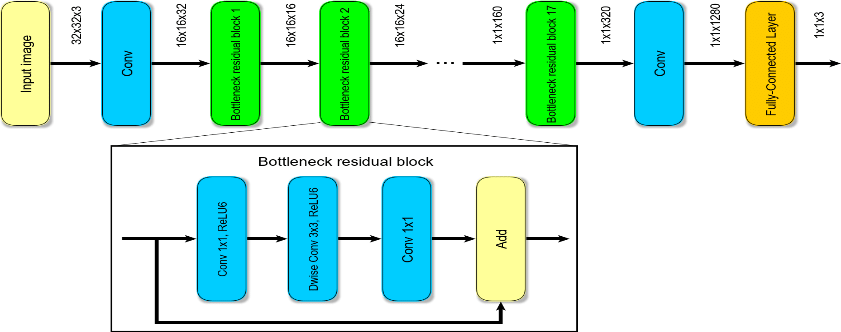
- MobileNetV2는 픽셀 값이 [-1 , 1] 사이에 있는 인풋을 받음
- 하지만 현재 데이터셋은 [0,255]의 값을 가지고 있음 
- 따라서 현재 모델에 preprocessing을 추가해야 함
- mobilenet_v2 모듈에서 제공하는 preprocess_input 매서드를 사용하거나 Rescaling 레이어를 사용

In [9]:
# 전처리를 위해 mobilenet_v2 모듈에서 제공하는 preprocess_input 매서드를 사용
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# 전처리를 위해 Rescaling 레이어를 사용해서 [0,255] 값을 [-1,1] 사이로 변환
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

##### 사전 훈련된 MobileNet V2 모델로부터 기본 모델 생성

In [11]:
# Create the base model from the pre-trained model MobileNet V2

# IMG_SIZE=(160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# MobileNet V2의 레이어를 가지고 오되, 마지막 레이어를 제외하고 베이스 모델을 가지고 옴
# 마지막 레이어는 ImageNet 데이터의 1000개 클래스 분류에 사용하는 레이어기 때문에, 현재의 데이터셋에는 불필요함
# tf.keras.applications에 있는 함수에서 include_top = False로 지정하여 해당 작업 수행
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2

In [12]:
image_batch, label_batch = next(iter(train_dataset))
# 첫번째 iteration에서 나오는 데이터 확인
feature_batch = base_model(image_batch)
print(feature_batch.shape)
# input : (160,160,3) 이미지
# ouput : (5,5,1280)
# 배치사이즈, 5, 5, 1280

(32, 5, 5, 1280)


### 특징추출 & set Model

In [13]:
base_model.trainable = False
# Feature Extraction : feature extractor 부분은 고정하고, 마지막 classifier만 학습
# 불러온 베이스 모델의 weight를 고정하려면 layer.trainable = False 옵션을 사용

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
# base model의 output에 대해 GlobalAveragePooling을 적용해 공간적인 정보를 풀링한 feature vector을 만드는 레이어를 적용
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
# 위의 레이어에서 나온 1280차원 벡터를 태스크 분류 문제로 매핑하는 Dense Layer을 쌓음
# 강아지이면 1, 고양이이면 0을 예측하도록 하는 1차원 아웃풋을 예측
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
# 지금까지 만든 Data Augmentation , Rescaling , base_model, Classification 레이어를 연결하여 하나의 모델을 만듦

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input(x) # 전처리
x = base_model(x, training=False) # MobileNet V2d의 basemodel
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model = tf.keras.Model(inputs, outputs)

##### Model Compile

In [18]:
base_learning_rate = 0.0001  # 학습률 지정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# loss로 BinaryCrossentropy 사용
# adam optimizer 사용
# metric : accuracy

In [19]:
model.summary()
len(model.trainable_variables)

# 마지막 dense layer에 있는 파라미터만이 학습 대상인것을 확인할 수 있음

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

2

##### Train Model & Evaluate

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 36ms/step - loss: 0.8679 - accuracy: 0.4394


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.44


In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 4s 43ms/step - loss: 0.7817 - accuracy: 0.5155 - val_loss: 0.6000 - val_accuracy: 0.6027
Epoch 2/10
63/63 [==============================] - 2s 33ms/step - loss: 0.5814 - accuracy: 0.6535 - val_loss: 0.4476 - val_accuracy: 0.7389
Epoch 3/10
63/63 [==============================] - 2s 33ms/step - loss: 0.4498 - accuracy: 0.7540 - val_loss: 0.3444 - val_accuracy: 0.8144
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3875 - accuracy: 0.8090 - val_loss: 0.2830 - val_accuracy: 0.8564
Epoch 5/10
63/63 [==============================] - 2s 34ms/step - loss: 0.3376 - accuracy: 0.8445 - val_loss: 0.2434 - val_accuracy: 0.8824
Epoch 6/10
63/63 [==============================] - 2s 34ms/step - loss: 0.2954 - accuracy: 0.8705 - val_loss: 0.2074 - val_accuracy: 0.9097
Epoch 7/10
63/63 [==============================] - 2s 33ms/step - loss: 0.2795 - accuracy: 0.8685 - val_loss: 0.1842 - val_accuracy: 0.9245
Epoch 8/10
63/63 [======

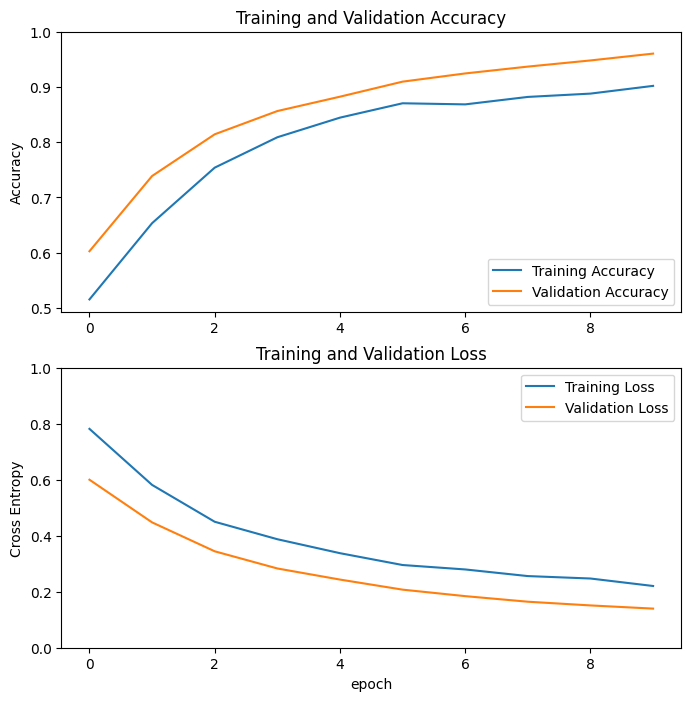

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Validation 데이터에서 정확도가 94%정도까지 올라가도록 모델이 수렴함
# 학습 데이터에 대한 Loss나 정확도보다 검증 데이터에서 Loss가 더 낮고 정확도가 높은 것을 확인함

### Fine_tuning (미세 조정)

In [24]:
base_model.trainable = True
# 최상위 층 고정 해제
# 맨 아래 층을 훈련 할 수 없도록 설정함

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# base_model의 파라미터들을 학습 가능하도록 하고 밑에서부터 n개 (100)개의 레이어만 고정

Number of layers in the base model:  154


In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

# 정의한 모델 컴파일

In [27]:
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

56

In [28]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# 모델 학습 진행
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 6s 54ms/step - loss: 0.1493 - accuracy: 0.9380 - val_loss: 0.1017 - val_accuracy: 0.9542
Epoch 11/20
63/63 [==============================] - 3s 44ms/step - loss: 0.1175 - accuracy: 0.9530 - val_loss: 0.0708 - val_accuracy: 0.9703
Epoch 12/20
63/63 [==============================] - 3s 44ms/step - loss: 0.1073 - accuracy: 0.9595 - val_loss: 0.0564 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 3s 44ms/step - loss: 0.1035 - accuracy: 0.9550 - val_loss: 0.0529 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 3s 45ms/step - loss: 0.0837 - accuracy: 0.9625 - val_loss: 0.0455 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 3s 44ms/step - loss: 0.0767 - accuracy: 0.9720 - val_loss: 0.0490 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 3s 44ms/step - loss: 0.0812 - accuracy: 0.9700 - val_loss: 0.0648 - val_accuracy: 0.9703
Epoch 17/20
63/63 

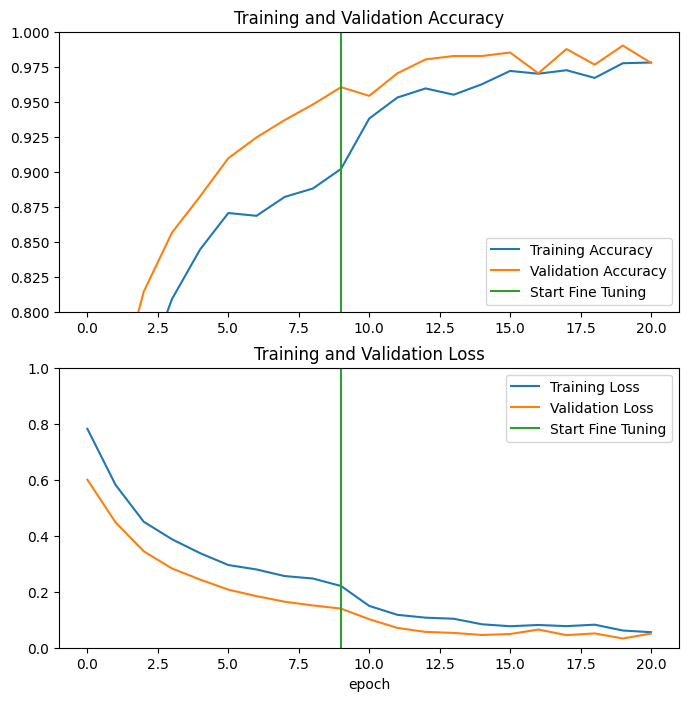

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Predict & Evaluation

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# 테스트 데이터로 떼어낸 데이터에 해대 모델 성능 평가

6/6 [==============================] - 0s 21ms/step - loss: 0.0639 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0]
Labels:
 [0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0]


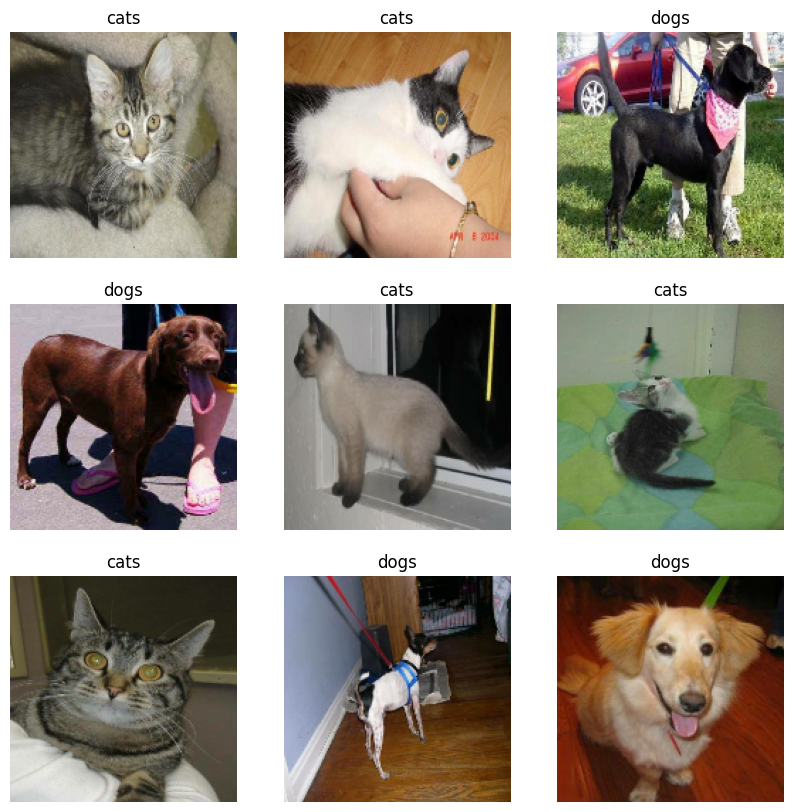

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

##### Confusion_matrix

In [32]:
import pandas as pd
from sklearn.metrics import confusion_matrix

conMatrix = confusion_matrix(predictions, label_batch.astype(float))
conMatrix

array([[18,  0],
       [ 1, 13]], dtype=int64)

In [33]:
cnt=len(conMatrix)
pd.DataFrame(conMatrix, 
             index=['true_%d' % i for i in range(cnt)],
             columns=['pred_%d' % i for i in range(cnt)] )

,pred_0,pred_1
true_0,18,0
true_1,1,13


Text(8.222222222222223, 0.5, 'true label')

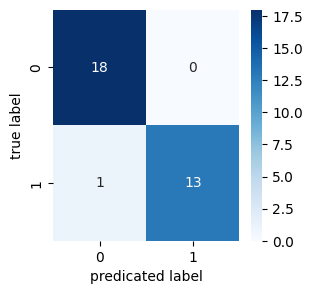

In [34]:
import seaborn as sns
plt.figure(figsize=(3,3))
sns.heatmap(conMatrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

##### 분류 리포트

In [35]:
from sklearn.metrics import classification_report

print(classification_report(label_batch, predictions, target_names=class_names))

              precision    recall  f1-score   support

        cats       1.00      0.95      0.97        19
        dogs       0.93      1.00      0.96        13

    accuracy                           0.97        32
   macro avg       0.96      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



##### ROC 커브

In [36]:
conMatrix[1][0]

1

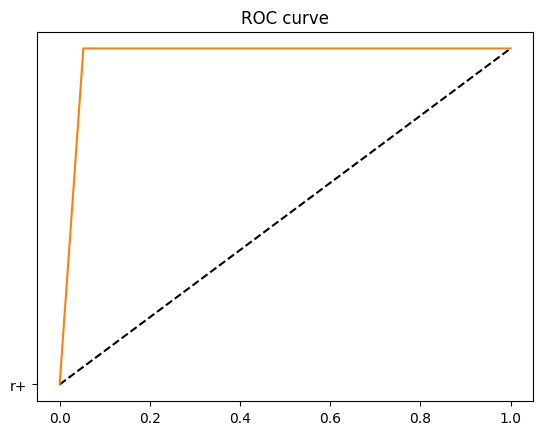

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(label_batch, predictions)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.show()


In [53]:
from glob import glob
from PIL import Image
import numpy as np
import os

base='d:/cat&dog/*.jpg'
fileList=glob(base)

for file in fileList:
    img=Image.open(file).resize((160,160)).convert('RGB')
    img=np.array(img)
    img=np.reshape(img, (1,160,160,3))

    pred = model.predict_on_batch(img).flatten()

    # Apply a sigmoid since our model returns logits
    pred = tf.nn.sigmoid(pred)
    pred = tf.where(pred < 0.5, 0, 1)

    print('Predictions:\n', pred.numpy())
    # print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(img.astype("uint8"))
#   plt.title(class_names[pred[i]])
#   plt.axis("off")

Predictions:
 [0]
Predictions:
 [0]
Predictions:
 [1]
